# CNN Model

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, utils
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import os

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report as cr

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using device:{device}")

using device:cpu


In [4]:
dataset_path = r"E:\126156008\Bean_Dataset\Bean_Dataset"

In [5]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ])

In [6]:
full_dataset = datasets.ImageFolder(root=dataset_path, transform = transform)

In [7]:
train_size = int(0.8*len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

In [8]:
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)

In [9]:
num_classes = len(full_dataset.classes)
class_names = full_dataset.classes

In [10]:
print("\nDataset Information:")
print(f"Total no. of classes: {num_classes}")
print(f"Class names: {class_names}")
print(f"No. of training images: {len(train_dataset)}")
print(f"No. of testing images: {len(test_dataset)}")


Dataset Information:
Total no. of classes: 3
Class names: ['angular_leaf_spot', 'bean_rust', 'healthy']
No. of training images: 792
No. of testing images: 198


In [11]:
def imshow(img, title = None):
    img = img.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std*img + mean
    img = np.clip(img, 0,1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis('off')

In [12]:
images, labels = next(iter(train_loader))
sample_images = images[:8]
sample_labels = labels[:8]

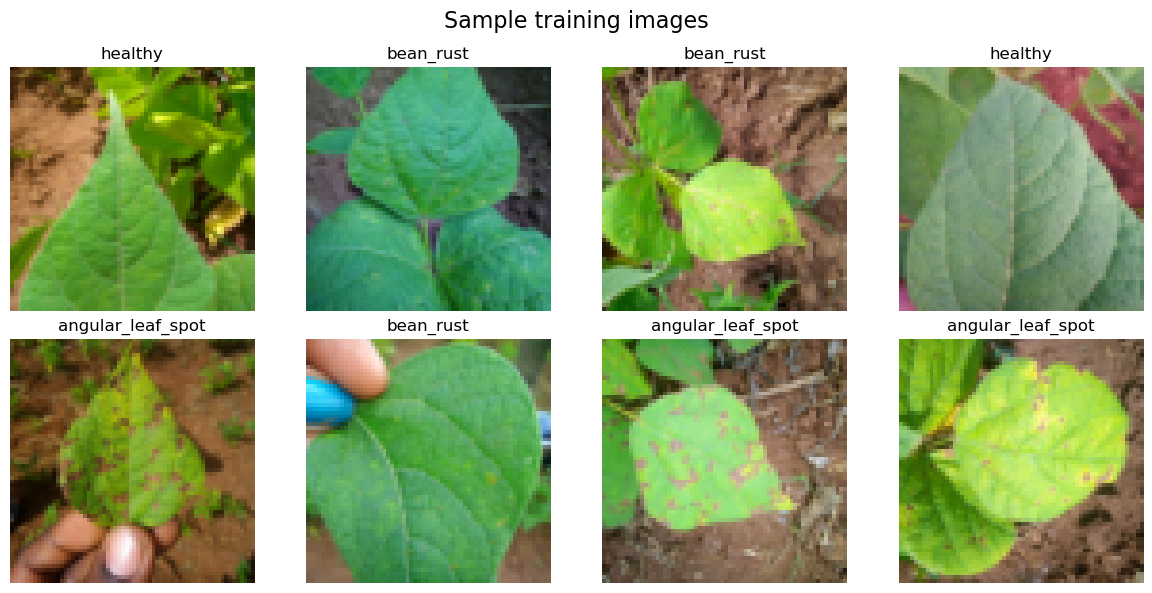

In [13]:
plt.figure(figsize = (12,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    imshow(sample_images[i], title = class_names[sample_labels[i]])
plt.suptitle('Sample training images', fontsize = 16)
plt.tight_layout()
plt.show()

In [14]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Calculate the size after convolutions and pooling
        self.fc1_input_size = 128 * (64 // 8) * (64 // 8)
        
        self.fc1 = nn.Linear(self.fc1_input_size, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.25)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Conv layer 1
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Conv layer 2
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Conv layer 3
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Flatten
        x = x.view(-1, self.fc1_input_size)
        
        # Fully connected layers
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [16]:
model = CNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

# Training loop
print("Starting training...\n")
for epoch in range(5):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{15}')
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': running_loss/(total/64),
            'acc': 100.*correct/total
        })
    
    # Store training metrics
    train_loss = running_loss/len(train_loader)
    train_acc = 100.*correct/total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Store validation metrics
    val_loss = val_loss/len(test_loader)
    val_acc = 100.*val_correct/val_total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)
    
    print(f'Epoch {epoch+1}/{15} - '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

print('\nTraining finished!')
cnn_final_train_acc = train_acc_history[-1]
cnn_final_val_acc = val_acc_history[-1]
cnn_final_train_loss = train_loss_history[-1]
cnn_final_val_loss = val_loss_history[-1]

Starting training...



Epoch 1/15: 100%|████████████████████████████████████████████████| 13/13 [00:05<00:00,  2.46it/s, loss=0.852, acc=65.4]


Epoch 1/15 - Train Loss: 0.8111, Train Acc: 65.40% | Val Loss: 0.8385, Val Acc: 68.69%


Epoch 2/15: 100%|████████████████████████████████████████████████| 13/13 [00:05<00:00,  2.44it/s, loss=0.697, acc=72.5]


Epoch 2/15 - Train Loss: 0.6639, Train Acc: 72.47% | Val Loss: 0.8555, Val Acc: 69.19%


Epoch 3/15: 100%|████████████████████████████████████████████████| 13/13 [00:05<00:00,  2.46it/s, loss=0.636, acc=73.1]


Epoch 3/15 - Train Loss: 0.6054, Train Acc: 73.11% | Val Loss: 0.8189, Val Acc: 70.71%


Epoch 4/15: 100%|██████████████████████████████████████████████████| 13/13 [00:05<00:00,  2.43it/s, loss=0.544, acc=77]


Epoch 4/15 - Train Loss: 0.5179, Train Acc: 77.02% | Val Loss: 0.8658, Val Acc: 70.71%


Epoch 5/15: 100%|████████████████████████████████████████████████| 13/13 [00:05<00:00,  2.41it/s, loss=0.448, acc=81.7]


Epoch 5/15 - Train Loss: 0.4268, Train Acc: 81.69% | Val Loss: 0.8197, Val Acc: 74.24%

Training finished!


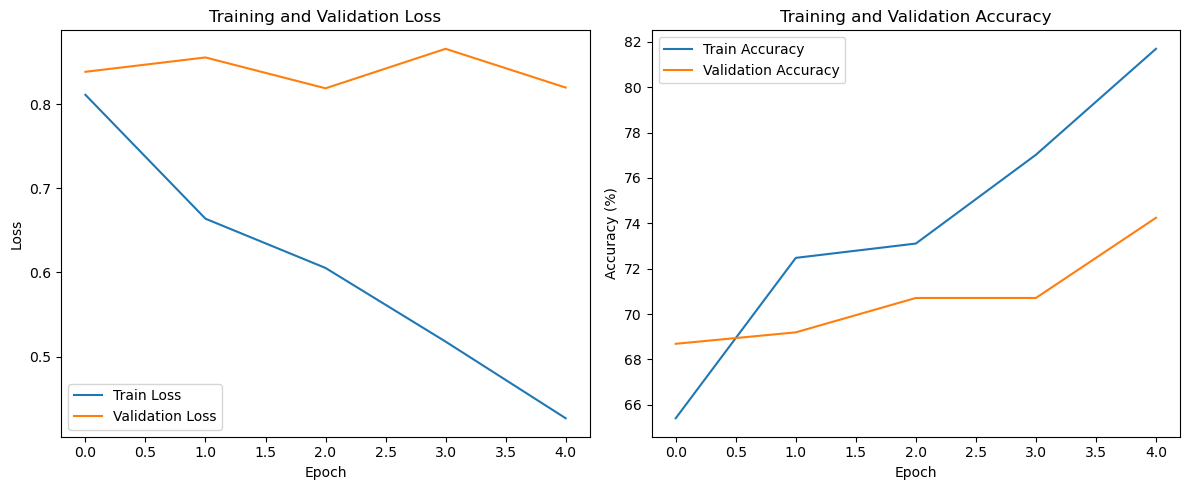

In [21]:
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

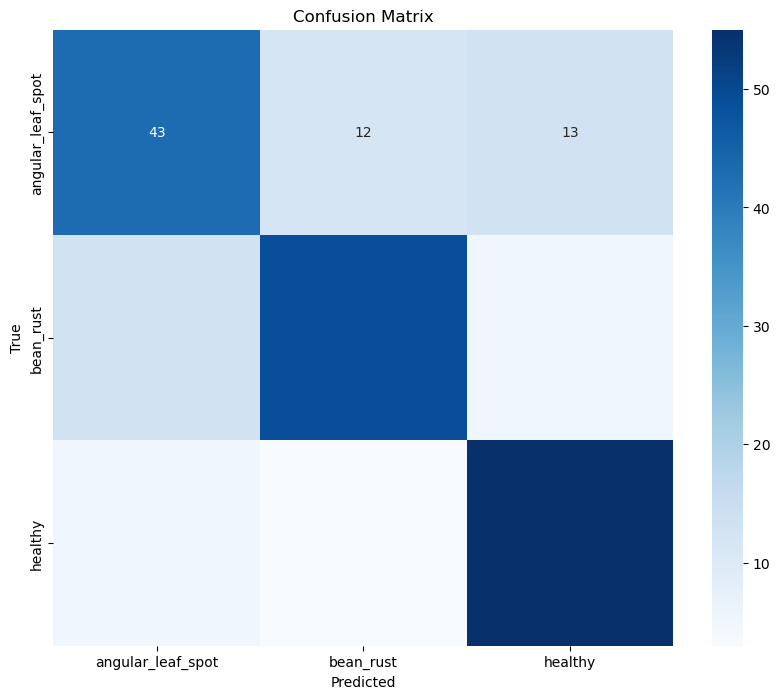

In [22]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

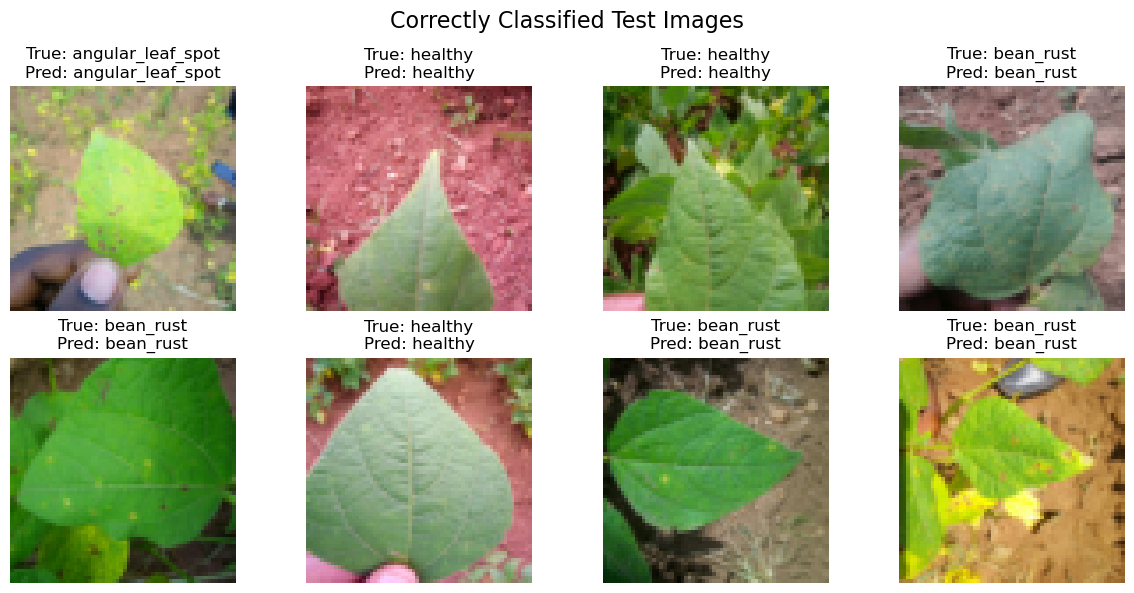

In [23]:
model.eval()
correct_images = []
correct_labels = []
correct_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        
        # Get correctly classified images
        correct_idx = (preds == labels).nonzero(as_tuple=True)[0]
        for idx in correct_idx:
            if len(correct_images) < 8:  # Only save up to 8 images
                correct_images.append(images[idx].cpu())
                correct_labels.append(labels[idx].cpu())
                correct_preds.append(preds[idx].cpu())

# Plot correctly classified images
plt.figure(figsize=(12, 6))
plt.suptitle('Correctly Classified Test Images', fontsize=16)
for i in range(min(8, len(correct_images))):
    plt.subplot(2, 4, i+1)
    imshow(correct_images[i])
    plt.title(f'True: {class_names[correct_labels[i]]}\nPred: {class_names[correct_preds[i]]}')
plt.tight_layout()
plt.show()

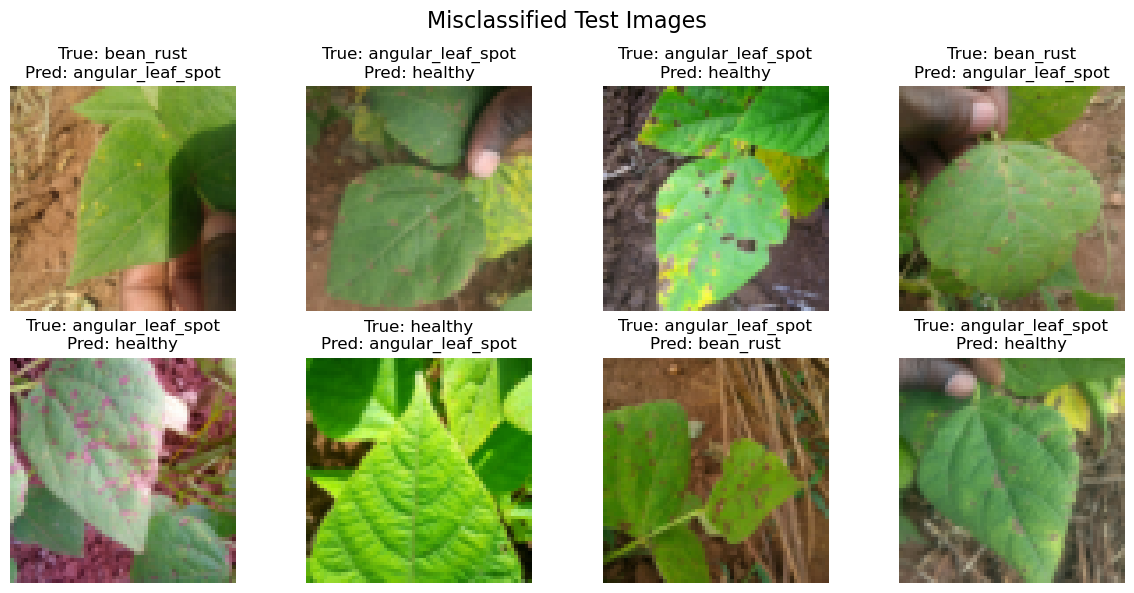


Model saved to enhanced_cnn_model.pth


In [24]:
model.eval()
wrong_images = []
wrong_labels = []
wrong_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        
        # Get misclassified images
        wrong_idx = (preds != labels).nonzero(as_tuple=True)[0]
        for idx in wrong_idx:
            if len(wrong_images) < 8:  # Only save up to 8 images
                wrong_images.append(images[idx].cpu())
                wrong_labels.append(labels[idx].cpu())
                wrong_preds.append(preds[idx].cpu())

# Plot misclassified images
if wrong_images:  # Only plot if there are misclassified images
    plt.figure(figsize=(12, 6))
    plt.suptitle('Misclassified Test Images', fontsize=16)
    for i in range(min(8, len(wrong_images))):
        plt.subplot(2, 4, i+1)
        imshow(wrong_images[i])
        plt.title(f'True: {class_names[wrong_labels[i]]}\nPred: {class_names[wrong_preds[i]]}')
    plt.tight_layout()
    plt.show()
else:
    print("\nNo misclassified images found!")

# Save the model
torch.save(model.state_dict(), 'enhanced_cnn_model.pth')
print('\nModel saved to enhanced_cnn_model.pth')

# DNN Model

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm
import os

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [27]:
num_epochs = 20
batch_size = 64
learning_rate = 0.001
input_size = 64

In [28]:
dataset_path = r"E:\126156008\Bean_Dataset\Bean_Dataset"

In [29]:
transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the image for DNN
])

In [30]:
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split into train and test sets
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

In [31]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Get number of classes and class names
num_classes = len(full_dataset.classes)
class_names = full_dataset.classes

# Calculate input dimension (3 channels * width * height)
input_dim = 3 * input_size * input_size

In [32]:
print(f"\nDataset Information:")
print(f"Total number of classes: {num_classes}")
print(f"Class names: {class_names}")
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of testing images: {len(test_dataset)}")
print(f"Input dimension: {input_dim}\n")


Dataset Information:
Total number of classes: 3
Class names: ['angular_leaf_spot', 'bean_rust', 'healthy']
Number of training images: 792
Number of testing images: 198
Input dimension: 12288



In [33]:
def imshow(img, title=None):
    """Display image tensor"""
    # For visualization, we'll use a transform without flattening
    viz_transform = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    temp_dataset = datasets.ImageFolder(root=dataset_path, transform=viz_transform)
    img = temp_dataset[0][0] if img is None else img  # Fallback if no image provided
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis('off')

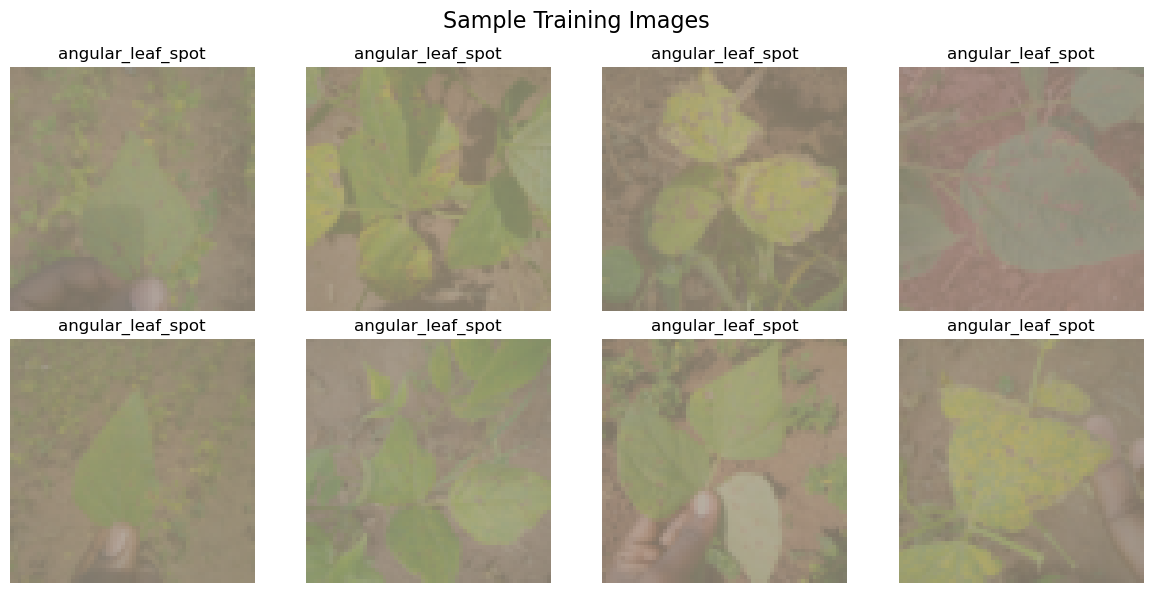

In [34]:
viz_dataset = datasets.ImageFolder(root=dataset_path, transform=transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor()
]))
sample_images = [viz_dataset[i][0] for i in range(8)]
sample_labels = [viz_dataset[i][1] for i in range(8)]

# Plot the images
plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    imshow(sample_images[i], title=class_names[sample_labels[i]])
plt.suptitle('Sample Training Images', fontsize=16)
plt.tight_layout()
plt.show()

In [35]:
class DNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc4(x)
        return x

# Initialize model
model = DNN(input_dim, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [36]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

# Lists to store metrics for plotting
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

# Training loop
print("Starting training...\n")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': running_loss/(total/batch_size),
            'acc': 100.*correct/total
        })
    
    # Store training metrics
    train_loss = running_loss/len(train_loader)
    train_acc = 100.*correct/total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Store validation metrics
    val_loss = val_loss/len(test_loader)
    val_acc = 100.*val_correct/val_total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs} - '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}% | '
          f'LR: {optimizer.param_groups[0]["lr"]:.6f}')

print('\nTraining finished!')
dnn_final_train_acc = train_acc_history[-1]
dnn_final_val_acc = val_acc_history[-1]
dnn_final_train_loss = train_loss_history[-1]
dnn_final_val_loss = val_loss_history[-1]

Starting training...



Epoch 1/20: 100%|█████████████████████████████████████████████████| 13/13 [00:03<00:00,  3.36it/s, loss=1.06, acc=51.8]


Epoch 1/20 - Train Loss: 1.0116, Train Acc: 51.77% | Val Loss: 0.8205, Val Acc: 64.14% | LR: 0.001000


Epoch 2/20: 100%|████████████████████████████████████████████████| 13/13 [00:03<00:00,  3.37it/s, loss=0.891, acc=62.5]


Epoch 2/20 - Train Loss: 0.8486, Train Acc: 62.50% | Val Loss: 0.7552, Val Acc: 67.68% | LR: 0.001000


Epoch 3/20: 100%|████████████████████████████████████████████████| 13/13 [00:03<00:00,  3.37it/s, loss=0.762, acc=68.4]


Epoch 3/20 - Train Loss: 0.7254, Train Acc: 68.43% | Val Loss: 0.6112, Val Acc: 71.21% | LR: 0.001000


Epoch 4/20: 100%|█████████████████████████████████████████████████| 13/13 [00:03<00:00,  3.36it/s, loss=0.64, acc=74.6]


Epoch 4/20 - Train Loss: 0.6095, Train Acc: 74.62% | Val Loss: 0.6982, Val Acc: 69.19% | LR: 0.001000


Epoch 5/20: 100%|████████████████████████████████████████████████| 13/13 [00:03<00:00,  3.37it/s, loss=0.533, acc=80.3]


Epoch 5/20 - Train Loss: 0.5070, Train Acc: 80.30% | Val Loss: 0.6586, Val Acc: 71.21% | LR: 0.001000


Epoch 6/20: 100%|████████████████████████████████████████████████| 13/13 [00:03<00:00,  3.38it/s, loss=0.374, acc=86.7]


Epoch 6/20 - Train Loss: 0.3561, Train Acc: 86.74% | Val Loss: 0.8315, Val Acc: 68.18% | LR: 0.000500


Epoch 7/20: 100%|████████████████████████████████████████████████| 13/13 [00:03<00:00,  3.38it/s, loss=0.349, acc=87.6]


Epoch 7/20 - Train Loss: 0.3325, Train Acc: 87.63% | Val Loss: 0.7729, Val Acc: 72.22% | LR: 0.000500


Epoch 8/20: 100%|████████████████████████████████████████████████| 13/13 [00:03<00:00,  3.39it/s, loss=0.277, acc=91.4]


Epoch 8/20 - Train Loss: 0.2633, Train Acc: 91.41% | Val Loss: 0.7220, Val Acc: 72.22% | LR: 0.000500


Epoch 9/20: 100%|████████████████████████████████████████████████| 13/13 [00:03<00:00,  3.38it/s, loss=0.212, acc=93.1]


Epoch 9/20 - Train Loss: 0.2016, Train Acc: 93.06% | Val Loss: 1.0510, Val Acc: 67.68% | LR: 0.000250


Epoch 10/20: 100%|███████████████████████████████████████████████| 13/13 [00:03<00:00,  3.38it/s, loss=0.226, acc=93.7]


Epoch 10/20 - Train Loss: 0.2147, Train Acc: 93.69% | Val Loss: 0.9739, Val Acc: 70.71% | LR: 0.000250


Epoch 11/20: 100%|███████████████████████████████████████████████| 13/13 [00:03<00:00,  3.36it/s, loss=0.138, acc=95.6]


Epoch 11/20 - Train Loss: 0.1313, Train Acc: 95.58% | Val Loss: 0.9409, Val Acc: 70.20% | LR: 0.000250


Epoch 12/20: 100%|███████████████████████████████████████████████| 13/13 [00:03<00:00,  3.35it/s, loss=0.116, acc=96.6]


Epoch 12/20 - Train Loss: 0.1103, Train Acc: 96.59% | Val Loss: 1.0774, Val Acc: 68.69% | LR: 0.000125


Epoch 13/20: 100%|██████████████████████████████████████████████| 13/13 [00:03<00:00,  3.39it/s, loss=0.0903, acc=97.1]


Epoch 13/20 - Train Loss: 0.0860, Train Acc: 97.10% | Val Loss: 1.0612, Val Acc: 69.19% | LR: 0.000125


Epoch 14/20: 100%|█████████████████████████████████████████████████| 13/13 [00:03<00:00,  3.38it/s, loss=0.092, acc=97]


Epoch 14/20 - Train Loss: 0.0876, Train Acc: 96.97% | Val Loss: 1.0742, Val Acc: 69.19% | LR: 0.000125


Epoch 15/20: 100%|██████████████████████████████████████████████| 13/13 [00:03<00:00,  3.37it/s, loss=0.0769, acc=97.9]


Epoch 15/20 - Train Loss: 0.0732, Train Acc: 97.85% | Val Loss: 1.1375, Val Acc: 68.69% | LR: 0.000063


Epoch 16/20: 100%|██████████████████████████████████████████████| 13/13 [00:03<00:00,  3.39it/s, loss=0.0633, acc=98.4]


Epoch 16/20 - Train Loss: 0.0602, Train Acc: 98.36% | Val Loss: 1.1282, Val Acc: 69.19% | LR: 0.000063


Epoch 17/20: 100%|██████████████████████████████████████████████| 13/13 [00:03<00:00,  3.39it/s, loss=0.0646, acc=98.7]


Epoch 17/20 - Train Loss: 0.0615, Train Acc: 98.74% | Val Loss: 1.1048, Val Acc: 71.21% | LR: 0.000063


Epoch 18/20: 100%|█████████████████████████████████████████████████| 13/13 [00:03<00:00,  3.35it/s, loss=0.077, acc=98]


Epoch 18/20 - Train Loss: 0.0733, Train Acc: 97.98% | Val Loss: 1.1360, Val Acc: 70.20% | LR: 0.000031


Epoch 19/20: 100%|██████████████████████████████████████████████| 13/13 [00:03<00:00,  3.31it/s, loss=0.0673, acc=97.9]


Epoch 19/20 - Train Loss: 0.0641, Train Acc: 97.85% | Val Loss: 1.1458, Val Acc: 68.69% | LR: 0.000031


Epoch 20/20: 100%|██████████████████████████████████████████████| 13/13 [00:03<00:00,  3.36it/s, loss=0.0578, acc=98.6]


Epoch 20/20 - Train Loss: 0.0550, Train Acc: 98.61% | Val Loss: 1.1479, Val Acc: 70.20% | LR: 0.000031

Training finished!


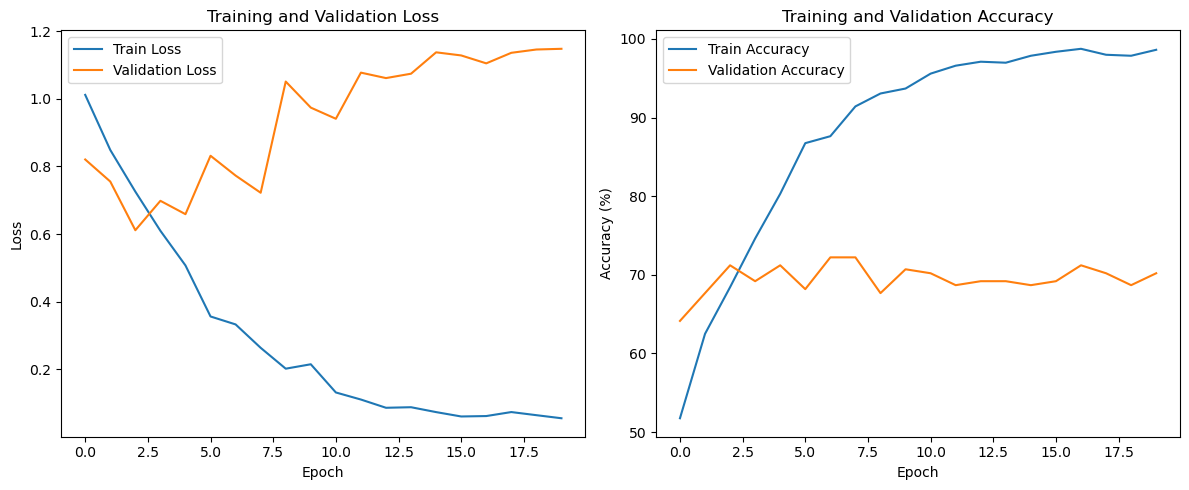

In [37]:
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

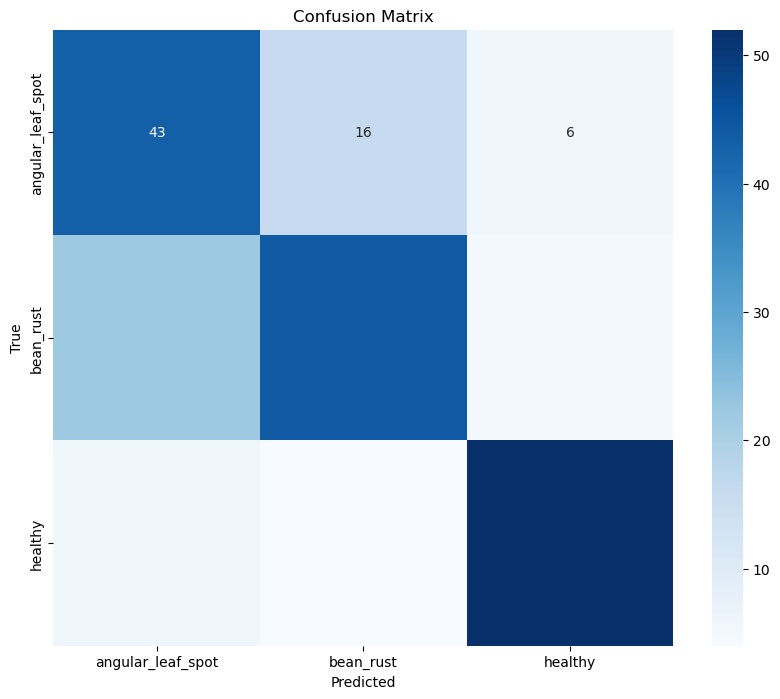

In [38]:
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

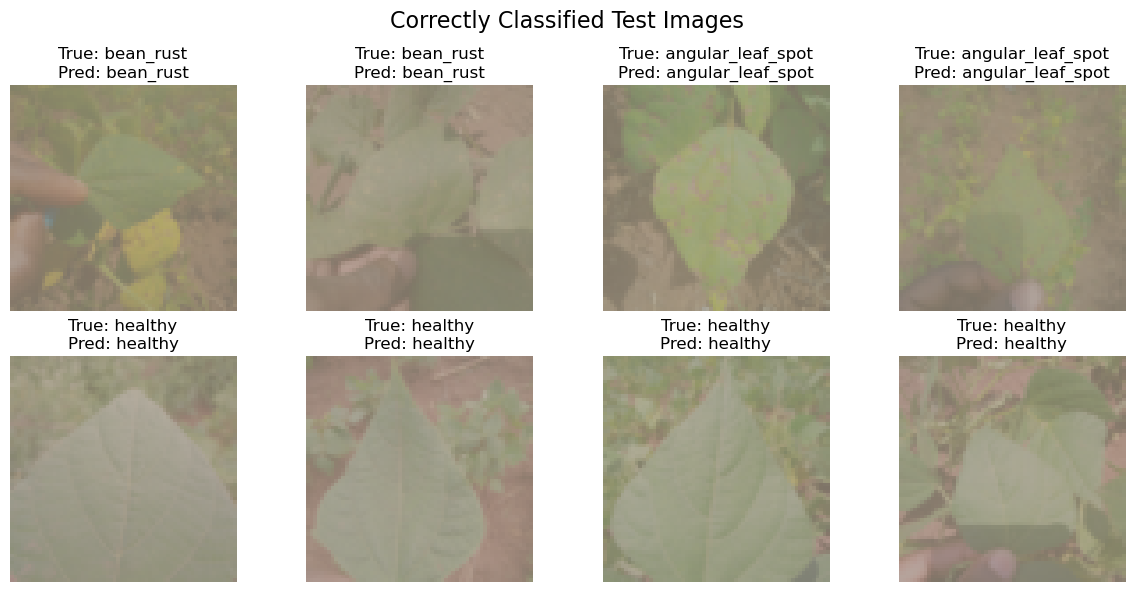

In [39]:
viz_test_dataset = datasets.ImageFolder(root=dataset_path, transform=transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor()
]))
viz_test_dataset = torch.utils.data.Subset(viz_test_dataset, test_dataset.indices)

model.eval()
correct_images = []
correct_labels = []
correct_preds = []

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        # Get flattened images for prediction
        flat_images = images.view(images.size(0), -1).to(device)
        labels = labels.to(device)
        outputs = model(flat_images)
        _, preds = outputs.max(1)
        
        # Get correctly classified images from original dataset
        for j in range(len(labels)):
            if preds[j] == labels[j] and len(correct_images) < 8:
                idx = i * batch_size + j
                if idx < len(viz_test_dataset):  # Ensure we don't go out of bounds
                    correct_images.append(viz_test_dataset[idx][0])
                    correct_labels.append(labels[j].cpu().item())
                    correct_preds.append(preds[j].cpu().item())

# Plot correctly classified images
plt.figure(figsize=(12, 6))
plt.suptitle('Correctly Classified Test Images', fontsize=16)
for i in range(min(8, len(correct_images))):
    plt.subplot(2, 4, i+1)
    imshow(correct_images[i])
    plt.title(f'True: {class_names[correct_labels[i]]}\nPred: {class_names[correct_preds[i]]}')
plt.tight_layout()
plt.show()

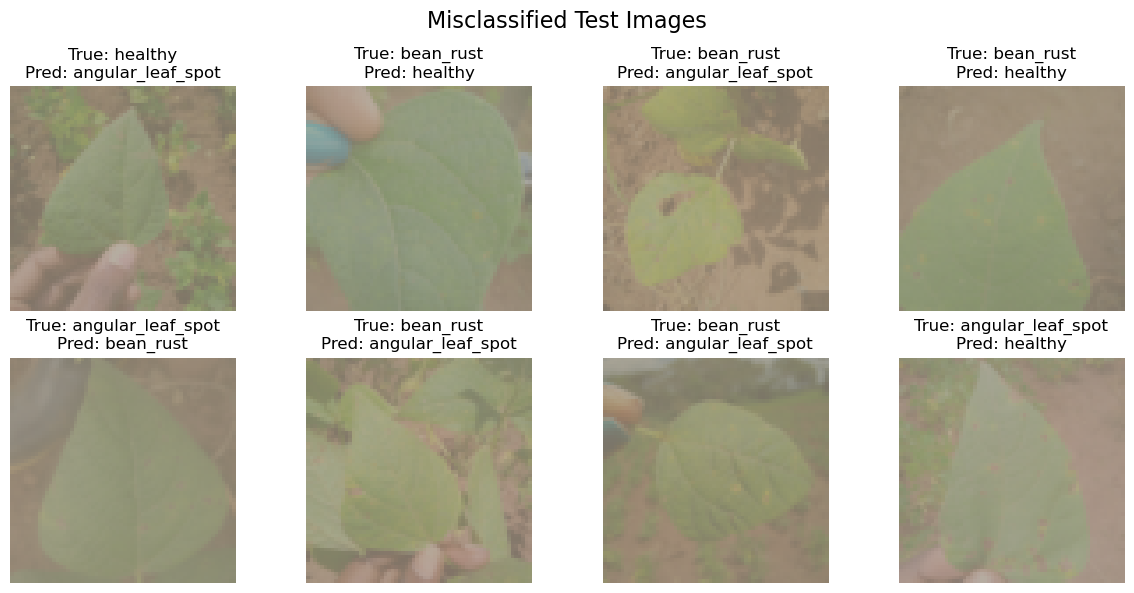


Model saved to dnn_model.pth

Final Training Accuracy: 98.61%
Final Validation Accuracy: 70.20%


In [40]:
model.eval()
wrong_images = []
wrong_labels = []
wrong_preds = []

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        # Get flattened images for prediction
        flat_images = images.view(images.size(0), -1).to(device)
        labels = labels.to(device)
        outputs = model(flat_images)
        _, preds = outputs.max(1)
        
        # Get misclassified images from original dataset
        for j in range(len(labels)):
            if preds[j] != labels[j] and len(wrong_images) < 8:
                idx = i * batch_size + j
                if idx < len(viz_test_dataset):  # Ensure we don't go out of bounds
                    wrong_images.append(viz_test_dataset[idx][0])
                    wrong_labels.append(labels[j].cpu().item())
                    wrong_preds.append(preds[j].cpu().item())

# Plot misclassified images
if wrong_images:  # Only plot if there are misclassified images
    plt.figure(figsize=(12, 6))
    plt.suptitle('Misclassified Test Images', fontsize=16)
    for i in range(min(8, len(wrong_images))):
        plt.subplot(2, 4, i+1)
        imshow(wrong_images[i])
        plt.title(f'True: {class_names[wrong_labels[i]]}\nPred: {class_names[wrong_preds[i]]}')
    plt.tight_layout()
    plt.show()
else:
    print("\nNo misclassified images found!")

# Save the model
torch.save(model.state_dict(), 'dnn_model.pth')
print('\nModel saved to dnn_model.pth')

# Print final metrics
print(f"\nFinal Training Accuracy: {train_acc_history[-1]:.2f}%")
print(f"Final Validation Accuracy: {val_acc_history[-1]:.2f}%")

# Comparision in Performance between CNN and DNN Model


===== Performance Comparison =====
Metric               CNN        DNN        Difference
Training Accuracy    81.69% 98.61% -16.92%
Validation Accuracy  74.24% 70.20% +4.04%
Training Loss        0.4268 0.0550 +0.3718
Validation Loss      0.8197 1.1479 -0.3281


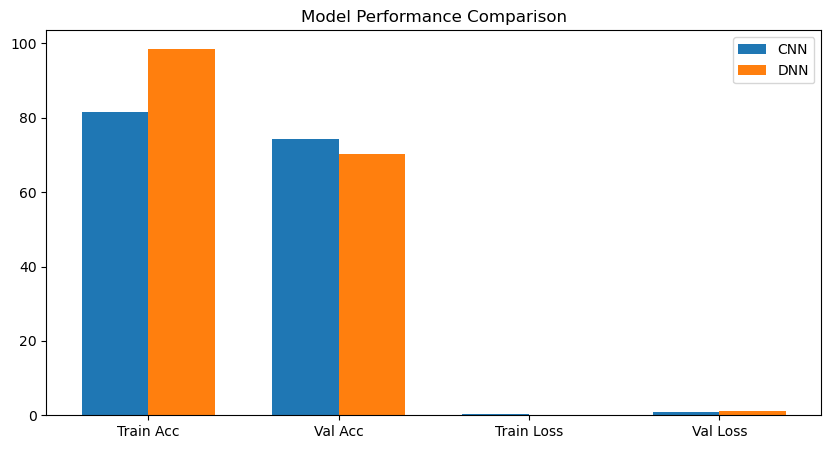

In [41]:
print("\n===== Performance Comparison =====")
print(f"{'Metric':<20} {'CNN':<10} {'DNN':<10} {'Difference':<10}")
print(f"{'Training Accuracy':<20} {cnn_final_train_acc:.2f}% {dnn_final_train_acc:.2f}% {cnn_final_train_acc-dnn_final_train_acc:+.2f}%")
print(f"{'Validation Accuracy':<20} {cnn_final_val_acc:.2f}% {dnn_final_val_acc:.2f}% {cnn_final_val_acc-dnn_final_val_acc:+.2f}%")
print(f"{'Training Loss':<20} {cnn_final_train_loss:.4f} {dnn_final_train_loss:.4f} {cnn_final_train_loss-dnn_final_train_loss:+.4f}")
print(f"{'Validation Loss':<20} {cnn_final_val_loss:.4f} {dnn_final_val_loss:.4f} {cnn_final_val_loss-dnn_final_val_loss:+.4f}")

# Visual comparison
plt.figure(figsize=(10, 5))
metrics = ['Train Acc', 'Val Acc', 'Train Loss', 'Val Loss']
cnn_values = [cnn_final_train_acc, cnn_final_val_acc, cnn_final_train_loss, cnn_final_val_loss]
dnn_values = [dnn_final_train_acc, dnn_final_val_acc, dnn_final_train_loss, dnn_final_val_loss]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, cnn_values, width, label='CNN')
plt.bar(x + width/2, dnn_values, width, label='DNN')
plt.title('Model Performance Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.show()